## ПРОЕКТ: ОПРЕДЕЛЕНИЕ СТОИМОСТИ АВТОМОБИЛЯ

### ОПИСАНИЕ ПРОЕКТА

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов.\
В нём можно будет узнать рыночную стоимость своего автомобиля.\
Заказчиком предоставлены данные о технических характеристиках, комплектации и ценах автомобилей.

### ЗАДАЧА ПРОЕКТА

Задача проекта - построение модели, которая сумеет определить цену автомобиля.\
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

### ПЛАН ПРОЕКТА

1. [Загрузка и изучение данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных](#3)
4. [Подготовка данных](#4)
5. [Обучение моделей](#5)
6. [Анализ моделей](#6)
7. [Общий вывод](#7)

<a id="1"></a>
# Загрузка и изучение данных

## Получение данных из файлов, запись в датафреймы

In [1]:
!pip install jupyter_black -q

In [2]:
!pip install -Uq scikit-learn

In [3]:
!pip install phik -q

In [4]:
!pip install missingno -q

Импортируем необходимые библиотеки

In [5]:
# импорт pandas и необходимых библиотек
import jupyter_black
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os
import pandas as pd
import re
import warnings

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from joblib import dump, load
from lightgbm import LGBMRegressor

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from phik.report import plot_correlation_matrix

warnings.filterwarnings("ignore")

jupyter_black.load()

RANDOM_STATE = 42

Откроем файлы, прочтем и запишем в переменные.

In [6]:
# объявление переменных
autos = "dataset.csv"
user_path = "..."
general_path = "..."


# функция для чтения файлов
def get_read_file(general_path, user_path, file, delimiter):
    path1 = os.path.join(general_path, file)
    path2 = os.path.join(user_path, file)

    try:
        if os.path.exists(os.path.join(path1)):
            return pd.read_csv(
                path1,
                sep=delimiter,
                parse_dates=["DateCrawled", "DateCreated", "LastSeen"],
                skipinitialspace=True,
            )
        elif os.path.exists(os.path.join(path2)):
            return pd.read_csv(
                path2,
                sep=delimiter,
                parse_dates=["DateCrawled", "DateCreated", "LastSeen"],
                skipinitialspace=True,
            )
    except Exception as err:
        print("Путь к файлу не найден!", err)


# чтение csv-файла в датафрейм с сохранением в переменную autos_df
autos_df = get_read_file(general_path, user_path, autos, ",")

# сохранение количества строк в переменную
autos_rows_before = autos_df.shape[0]

***

**ВЫВОД:**

1. Данные получены и записаны в датафрейм ***autos_df***

## Изучение данных

Изучим общую информацию о полученном датафрейме

In [7]:
# вывод первых 5-ти строчек датафрейма
autos_df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [8]:
# вывод основной информации о датафрейме
autos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Обратим внимание на наименование столбцов в датафрейме

In [9]:
# вывод наименований столбцов в датафреймах
print(*autos_df.columns.tolist(), sep="\n")

DateCrawled
Price
VehicleType
RegistrationYear
Gearbox
Power
Model
Kilometer
RegistrationMonth
FuelType
Brand
Repaired
DateCreated
NumberOfPictures
PostalCode
LastSeen


Переименуем столбцы:

 - приведём наименования столбцов к нижнему регистру
 - слова соединим нижним подчёркиванием

In [10]:
# функция для переименования столбцов в датафреймах
def rename_columns(df):
    lst_columns = df.columns.to_list()
    new_lst_columns = []
    for col in lst_columns:
        col = "_".join(re.sub(r"([A-Z])", r" \1", col).split()).lower()
        new_lst_columns.append(col)
    df.columns = new_lst_columns


# переименование столбцов
rename_columns(autos_df)
# проверка переименования
print(*autos_df.columns.tolist(), sep="\n")

date_crawled
price
vehicle_type
registration_year
gearbox
power
model
kilometer
registration_month
fuel_type
brand
repaired
date_created
number_of_pictures
postal_code
last_seen


***

***ВЫВОД:***

1. Пропуски в данных есть в нескольких столбцах.
2. В результате изучения общей информации о датафрейме обнаружено некорректное наименование столбцов:
    - сочетание прописных и строчных букв
    - стиль написания, отличный от "lower_case_with_underscores"
3. Наименования столбцов приведены к стандартам оформления данных.

<a id='2'></a>
# Предобработка данных

## Предобработка пропусков

Проверим данные на пропущенные значения

In [11]:
# вывод пропусков по столбцам
autos_df.isna().sum().sort_values(ascending=False)

repaired              71154
vehicle_type          37490
fuel_type             32895
gearbox               19833
model                 19705
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [12]:
# вывод доли пропущенных значений для каждого столбца
autos_df.isna().mean().sort_values(ascending=False).round(4) * 100

repaired              20.08
vehicle_type          10.58
fuel_type              9.28
gearbox                5.60
model                  5.56
date_crawled           0.00
price                  0.00
registration_year      0.00
power                  0.00
kilometer              0.00
registration_month     0.00
brand                  0.00
date_created           0.00
number_of_pictures     0.00
postal_code            0.00
last_seen              0.00
dtype: float64

Доля пропусков в датафрейме значительна, поэтому удаление пропусков невозможно без потери репрезентативности данных.

Изучим возможные взаимосвязи в пропущенных значениях

<Axes: >

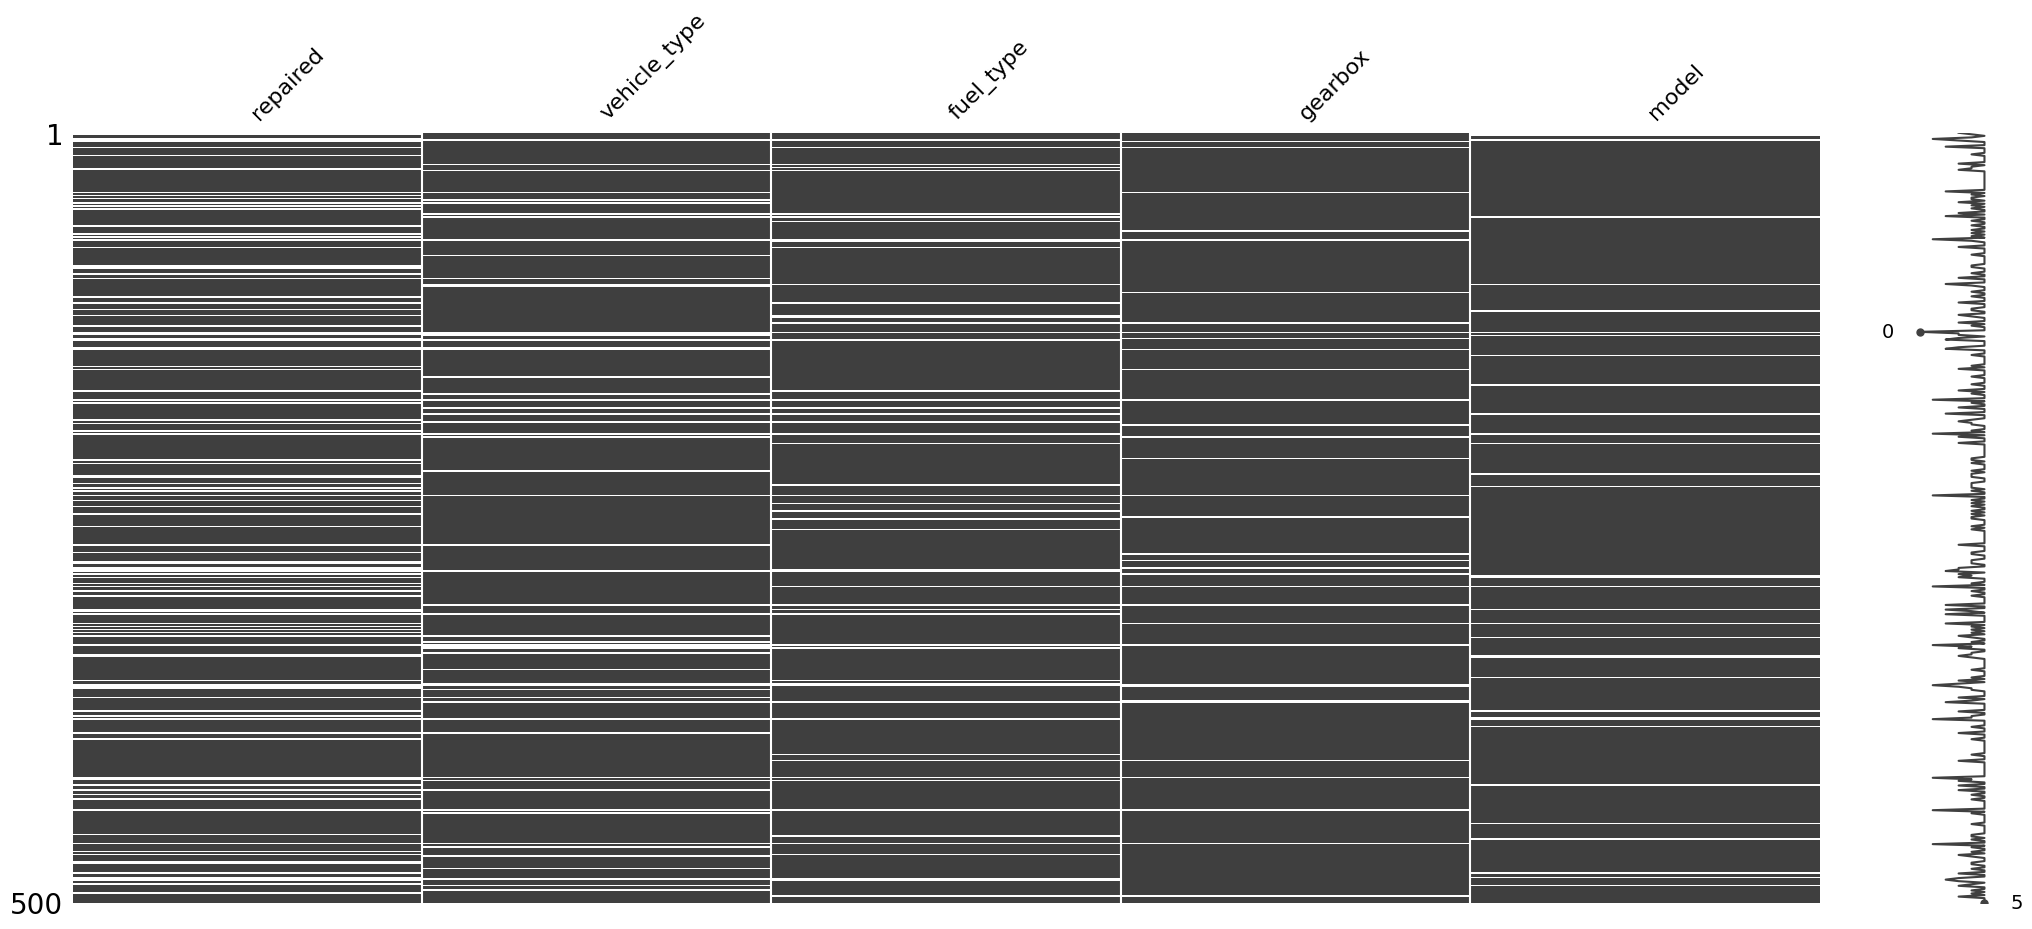

In [13]:
# визуализация пропусков на случайной выборке
msno.matrix(
    autos_df[["repaired", "vehicle_type", "fuel_type", "gearbox", "model"]].sample(500)
)

Визуализация показывает наличие некоторой взаимосвязи среди пропущенных значений

Изучим корреляцию столбцов с пропусками на тепловой карте

<Axes: >

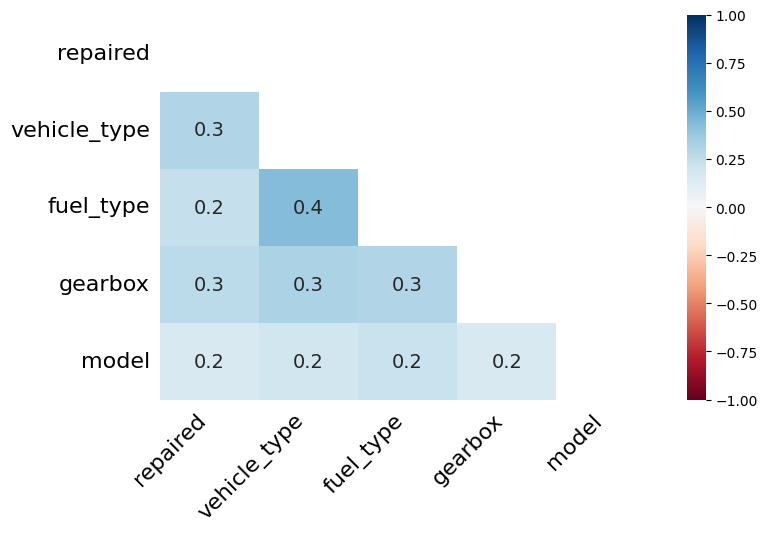

In [14]:
# рассчитаем корреляцию
msno.heatmap(
    autos_df[["repaired", "vehicle_type", "fuel_type", "gearbox", "model"]],
    figsize=(8, 5),
)

Корреляция пропусков между переменными в столбцах низкая.

Заполним пропуски в столбце `'model'` самыми часто встречающимися значениями\
для признака **"бренд"** (столбец `'brand'`).

In [15]:
# группировка по признаку
brand_grp = autos_df.groupby(["brand"])

# заполнение пропусков в столбце 'model'
autos_df["model"] = brand_grp.model.transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x)
)

Также заполним пропуски в столбцах `'vehicle_type'`, `'fuel_type'` и `'gearbox'`\
самыми часто встречающимися значениями\
для признака **"модель"** (столбец `'model'`).

In [16]:
# группировка по признаку
model_grp = autos_df.groupby(["model"])

# заполнение пропусков в столбце 'vehicle_type'
autos_df["vehicle_type"] = model_grp.vehicle_type.transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x)
)

Заполним пропуски в столце `'fuel_type'`

In [17]:
# заполнение пропусков в столбце 'fuel_type'
autos_df["fuel_type"] = model_grp.fuel_type.transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x)
)

Заполним пропуски в столбце `'gearbox'`

In [18]:
# заполнение пропусков в столбце 'gearbox'
autos_df["gearbox"] = model_grp.gearbox.transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x)
)

Проверим заполнение пропущенных значений

In [19]:
# вывод пропусков по столбцам
autos_df.isna().sum().sort_values(ascending=False)

repaired              71154
vehicle_type           3374
gearbox                3374
model                  3374
fuel_type              3374
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Можно предположить, что признак `'repaired'` был не заполнен в случае, если машина не была в ремонте.

Заполним пропуски в `'repaired'` значением *'no'*

In [20]:
# заполнение пропусков в столбце
autos_df["repaired"] = autos_df["repaired"].fillna("no")

Посмотрим на процентное соотношение пропущенных значений

In [21]:
# вывод строк с пропусками
autos_df.isna().mean().sort_values(ascending=False).round(4) * 100

vehicle_type          0.95
gearbox               0.95
model                 0.95
fuel_type             0.95
date_crawled          0.00
price                 0.00
registration_year     0.00
power                 0.00
kilometer             0.00
registration_month    0.00
brand                 0.00
repaired              0.00
date_created          0.00
number_of_pictures    0.00
postal_code           0.00
last_seen             0.00
dtype: float64

Найдём общее количество строк с пропусками и определим процент этих строк в датафрейме.

In [22]:
# вывод количества строк с пропусками
print(
    f'{round((autos_df.query("gearbox.isna()|model.isna()|vehicle_type.isna()|fuel_type.isna()").shape[0]/autos_rows_before*100),2)}%'
)

0.95%


Такое количество строк можно удалить

In [23]:
# удаление строк по условию
autos_df = autos_df.drop(
    autos_df[
        (autos_df["model"].isna())
        | (autos_df["vehicle_type"].isna())
        | (autos_df["fuel_type"].isna())
    ].index
).reset_index(drop=True)

In [24]:
# вывод общей информации о датафрейме
autos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350995 entries, 0 to 350994
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        350995 non-null  datetime64[ns]
 1   price               350995 non-null  int64         
 2   vehicle_type        350995 non-null  object        
 3   registration_year   350995 non-null  int64         
 4   gearbox             350995 non-null  object        
 5   power               350995 non-null  int64         
 6   model               350995 non-null  object        
 7   kilometer           350995 non-null  int64         
 8   registration_month  350995 non-null  int64         
 9   fuel_type           350995 non-null  object        
 10  brand               350995 non-null  object        
 11  repaired            350995 non-null  object        
 12  date_created        350995 non-null  datetime64[ns]
 13  number_of_pictures  350995 no

***

**ВЫВОД:**

1. В датафрейме наблюдается большое количество пропусков:

   |Пропусков|`'repaired'`|`'vehicle_type'`|`'fuel_type'`|`'gearbox'`|`'model'`|
   |-|-:|-:|-:|-:|-:|
   |количество|71154|37490|32895|19833|19705|
   |процент|20.08|10.58|9.28|5.6|5.56|

2. Так как пропусков большое количество, их нельзя просто удалить.
3. Пропуски во входном признаке `'model'` были заполнены самыми часто встречающимися значениями для входного признака `'brand'`
4. Пропуски во входных признаках:
    - `'vehicle_type'`
    - `'fuel_type'`
    - `'gearbox'`\
были заполнены самыми часто встречающимися значениями для входного признака `'model'`
5. Пропуски во входном признаке `'repaired'` были заполнены значением ***'no'***

## Предобработка явных дубликатов

Выведем количество явных дубликатов

In [25]:
# вывод количества явных дубликатов датафрейма
print(autos_df.duplicated().sum())

5


Удалим выявленные явные дубликаты в датафрейме

In [26]:
# удаление явных дубликатов
autos_df = autos_df.drop_duplicates().reset_index(drop=True)

***

**ВЫВОД:**

1. В датафрейме обнаружены 5 явных дубликатов.
2. Явные дубликаты были удалены.

## Предобработка типов данных

Обратим внимание на типы данных в таблице

In [27]:
# вывод типов данных в столбцах в датафреймах
print(autos_df.dtypes)

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
repaired                      object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen             datetime64[ns]
dtype: object


Тип данных входного признака `'repaired'` - *object*.\
Этот признак имеет только 2 значения: *yes* и *no*.\
Он должен быть бинарным.\
Преобразуем тип данных признака при кодировании в пайплайне.

***

**ВЫВОД:**

1. Тип данных входного признака `'repaired'` не соответствует данным:
    тип данных в данный момент - *object*,
    нужный тип данных - категориальный бинарный.
2. Преобразование типа данных признака `'repaired'` необходимо провести в пайплайне.

## Предобработка неявных дубликатов

Проверим данные на наличие неявных дубликатов.\
Выведем значения в колонках со строковым типом данных для датафрейма\
кроме колонки `'model'`

In [28]:
# объявление функции для вывода уникальных значений столбцов со строковым типом данных
def get_str_values(df):
    obj_lst = df.select_dtypes(include="object").columns.to_list()
    for col in obj_lst:
        print("---------")
        print(f"Признак <{col}>")
        print(sorted(list(set(df[col].to_list()))))
        print(f"Уникальных значений признака: {df[col].nunique()}")


# вызов функции для датафрейма
get_str_values(autos_df.drop(["model"], axis=1))

---------
Признак <vehicle_type>
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']
Уникальных значений признака: 8
---------
Признак <gearbox>
['auto', 'manual']
Уникальных значений признака: 2
---------
Признак <fuel_type>
['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']
Уникальных значений признака: 7
---------
Признак <brand>
['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']
Уникальных значений признака: 39
---------
Признак <repaired>
['no', 'yes']
Уникальных значений признака: 2


Неявных дубликатов в значениях строковых признаков не обнаружено.

Выведем неявные дубликаты признака `'model'`

In [29]:
# вывод неявных дубликатов признака 'model'
for i in sorted(list(set(autos_df["model"].to_list()))):
    print(i, process.extract(i, autos_df["model"].unique(), limit=3))

100 [('100', 100), ('500', 67), ('900', 67)]
145 [('145', 100), ('156', 67), ('147', 67)]
147 [('147', 100), ('145', 67), ('a4', 45)]
156 [('156', 100), ('159', 67), ('145', 67)]
159 [('159', 100), ('156', 67), ('r19', 67)]
1_reihe [('1_reihe', 100), ('2_reihe', 86), ('3_reihe', 86)]
1er [('1er', 100), ('3er', 67), ('5er', 67)]
200 [('200', 100), ('100', 67), ('500', 67)]
2_reihe [('2_reihe', 100), ('3_reihe', 86), ('z_reihe', 86)]
300c [('300c', 100), ('c4', 60), ('c1', 60)]
3_reihe [('3_reihe', 100), ('2_reihe', 86), ('z_reihe', 86)]
3er [('3er', 100), ('5er', 67), ('1er', 67)]
4_reihe [('4_reihe', 100), ('2_reihe', 86), ('3_reihe', 86)]
500 [('500', 100), ('100', 67), ('v50', 67)]
5_reihe [('5_reihe', 100), ('2_reihe', 86), ('3_reihe', 86)]
5er [('5er', 100), ('3er', 67), ('1er', 67)]
601 [('601', 100), ('s60', 67), ('v60', 67)]
6_reihe [('6_reihe', 100), ('2_reihe', 86), ('3_reihe', 86)]
6er [('6er', 100), ('3er', 67), ('5er', 67)]
7er [('7er', 100), ('3er', 67), ('5er', 67)]
80 [(

Обнаружены неявные дубликаты в значениях признака `'model'`:\
*"rangerover"* и *"range_rover"*.\
Приведём значения к единому виду *"range_rover"*

In [30]:
# перезапись значения
autos_df[autos_df["model"] == "rangerover"]["model"] = "range_rover"

***

**ВЫВОД:**

1. Данные были проверены на наличие неявных дубликатов значений.
2. В значениях входного признака `'model'` были обнаружены неявные дубликаты в 2-х значениях:
    *"range_rover"* и *"rangerover"*
4. Значения приведены к единому виду - *"range_rover"*

## Предобработка признаков

Количественные признаки `'postal_code'` ,`'registration_month'` и `'number_of_pictures'` - неинформативны для предсказания цены авто.\
`'postal_code'` - почтовый индекс владельца анкеты (пользователя): территориальное влияние сомнительно.\
`'registration_month'` - месяц регистрации автомобиля: не имеет такого влияния на цену, как год регистрации.\
`'number_of_pictures'` - количество фотографий автомобиля: возможно влияние на цену при наличии фото, но их нет.

Признаки с указанием даты и времени `'date_crawled'`, `'date_created'` и `'last_seen'` - также неинформативны для предсказания цены авто.\
`'date_crawled'` - дата скачивания анкеты из базы: не имеет влияния на цену.\
`'date_created'` - дата создания анкеты: для будущих анкет информация не актуальна.\
`'last_seen'` - дата последней активности пользователя: не имеет к цене отношения.

Прежде, чем удалять неинформативные признаки, получим диапазон дат по каждому признаку с датой и временем.

In [31]:
for item in ["date_crawled", "date_created", "last_seen"]:
    print(f"Признак <{item}> имеет значения:")
    print(f"- минимальное: {autos_df[item].min()}")
    print(f"- максимальное: {autos_df[item].max()}")
    print("-----------")

Признак <date_crawled> имеет значения:
- минимальное: 2016-03-05 14:06:22
- максимальное: 2016-04-07 14:36:58
-----------
Признак <date_created> имеет значения:
- минимальное: 2014-03-10 00:00:00
- максимальное: 2016-04-07 00:00:00
-----------
Признак <last_seen> имеет значения:
- минимальное: 2016-03-05 14:15:08
- максимальное: 2016-04-07 14:58:51
-----------


Удалим неинформативные признаки.

In [32]:
# перезапись датафрейма
autos_df = autos_df.drop(
    [
        "postal_code",
        "registration_month",
        "number_of_pictures",
        "date_crawled",
        "date_created",
        "last_seen",
    ],
    axis=1,
).reset_index(drop=True)

В значениях признаков присутствует *"other"*\
Определим количество таких значений.

In [33]:
# вывод количества строк датафрейма по условию
autos_df.query(
    '(vehicle_type == "other") | (gearbox == "other") | (model == "other")'
).shape[0]

27526

Заменим это значение на *"unknown"*

In [34]:
# замена значений в признаках
autos_df.loc[
    (autos_df["vehicle_type"] == "other")
    | (autos_df["gearbox"] == "other")
    | (autos_df["model"] == "other"),
    ["vehicle_type", "gearbox", "model"],
] = "unknown"

***

**ВЫВОД:**

1. Был получен диапазон дат по каждому признаку с датой и временем.
2. Входные признаки были признаны неинформативными:
    - `'postal_code'`
    - `'registration_month'`
    - `'number_of_pictures'`
    - `'date_crawled'`
    - `'date_created'`
    - `'last_seen'`
3. Неинформативные признаки были удалены.
4. Было определено количество строк датафрейма со значением признаков *"other"* - 27526 строк
5. Эти значения были заменены на *"unknown"*

<a id='3'></a>
# Исследовательский анализ данных

## Анализ количественных признаков датафрейма

Проведем статистический анализ признаков

Выведем описательную статистику для количественных признаков датафрейма

In [35]:
# создание списка количественных признаков
autos_num_lst = autos_df.select_dtypes(include=["number"]).columns.to_list()

# вывод описательной статистики для количественных признаков датасета
autos_df[[*autos_num_lst]].describe().round(3)

,price,registration_year,power,kilometer
count,350990.000,350990.000,350990.000,350990.000
mean,4410.798,2004.067,110.267,128574.518
std,4503.347,79.124,189.082,37470.219
min,0.000,1000.000,0.000,5000.000
25%,1099.000,1999.000,69.000,125000.000
50%,2700.000,2003.000,105.000,150000.000
75%,6399.000,2008.000,142.000,150000.000
max,20000.000,9999.000,20000.000,150000.000


В датафрейме присутствуют аномальные значения количественных признаков:
 - `'registration_year'` - от 1000 до 9999
 - `'power'` - до 20000

Также в датафрейме присутствуют нулевые значения в признаках:
 - `'price'`
 - `'power'`

### Предобработка нулевых значений

Так как признак `'price'` является целевым, то нулевые значения в нём недопустимы.\
Найдём нулевые значения признака.

In [36]:
# вывод количества нулевых значений признака
autos_df[autos_df["price"] == 0].shape[0]

10245

Это составляет

In [37]:
# вывод процентного соотношения количества нулевых значений признака
print(
    f'{round((autos_df[autos_df["price"] == 0].shape[0] / autos_df.shape[0] * 100), 2)} %'
)

2.92 %


Такое количество целевого признака можно удалить

In [38]:
# удаление нулевых значений в признаке
autos_df = autos_df.loc[autos_df["price"] != 0].reset_index(drop=True)

Посмотрим на нулевые значения признака `'power'`

In [39]:
# вывод количества нулевых значений признака
autos_df[autos_df["power"] == 0].shape[0]

35421

Нулевых значений признака `'power'` много для удаления.

Заполним медианой для каждой уникальной пары признаков `'brand'` и `'model'`\
Так как в признаке много выбросов, перед заполнением сначала обработаем выбросы.

***

**ВЫВОД:**

1. Нулевых значений целевого признака `'price'` - 10245, что составляет 2,92% строк датафрейма.
2. Строки с нулевыми значениями целевого признака `'price'` были удалены.
3. Нулевых значений целевого признака `'power'` - 35421, что много для удаления.

### Предобработка аномальных значений и выбросов

Для большей наглядности и выявления выбросов построим диаграммы размаха для количественных признаков датафрейма.

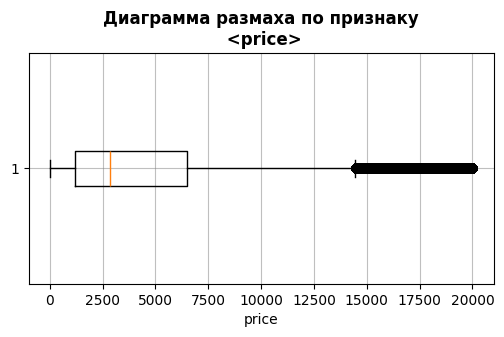

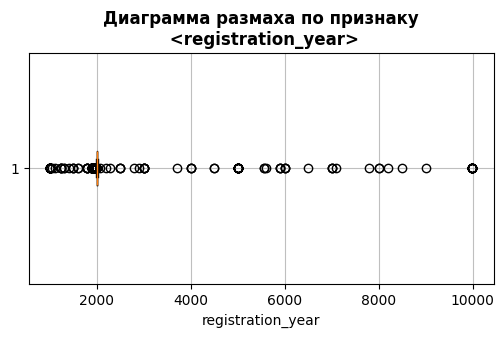

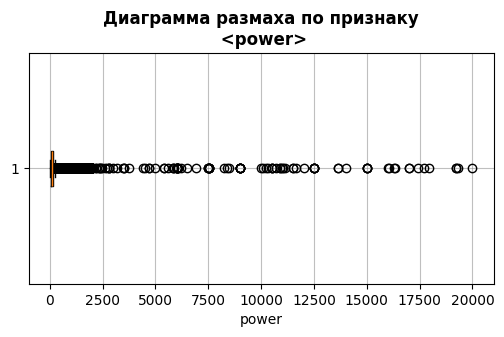

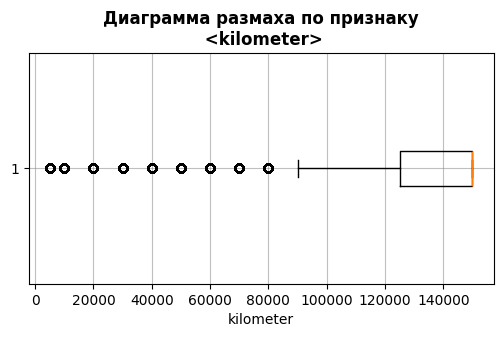

In [40]:
# функция для построения диаграммы размаха
def get_boxplot(df, item):
    plt.rcParams["figure.figsize"] = (
        6,
        3,
    )  # установка параметров графика: размер фигуры

    plt.boxplot(df[item], vert=False)
    plt.title(
        f"Диаграмма размаха по признаку\n <{item}>",
        weight="bold",
    )
    plt.xlabel(f"{item}")
    plt.grid(color="grey", axis="both", alpha=0.5)
    plt.show()


# построение графиков
def set_plot(df, item_lst, plot):
    for item in item_lst:
        plot(df, item)


# построение диаграммы размаха для количественных признаков датасета
set_plot(autos_df, autos_num_lst, get_boxplot)

На диаграммах размаха:
 - по признаку `'price'` - выше края статистически значимой выборки большое количество выбросов,\
    также присутствуют значения около нуля.
 - по признаку `'registration_year'` - большое количество выбросов выше и ниже края статистически значимой выборки.
 - по признаку `'power'` - выше края статистически значимой выборки большое количество выбросов,\
    также присутствуют значения около нуля.
 - по признаку `'kilometer'` - есть несколько выбросов ниже края статистически значимой выборки.

#### Признак *'power'*

На данный момент известно о пределах мощности автомобилей:
 - Benz Patent Motorwagen - 0,75 л.с. - самый маломощный автомобиль
 - Koenigsegg Gemera - 2300 л.с. - самый мощный автомобиль.

Найдём количество значений признака `'power'`, выходящее за пределы этих значений.

In [41]:
# вывод количества строк по условию
autos_df.query("(power < 0.75) | (power > 2300)").shape[0]

35519

Заполним значения медианой для каждой уникальной пары признаков `'brand'` и `'model'`

In [42]:
# группировка по парам признаков
power_grp = autos_df.pivot_table(
    values="power", index=["brand", "model"], aggfunc="median"
)

# заполнение значений признака 'power'
for index in power_grp.index:
    autos_df.loc[
        (
            (autos_df["brand"] == index[0])
            & (autos_df["model"] == index[1])
            & ((autos_df["power"] < 0.75) | (autos_df["power"] > 2300))
        ),
        "power",
    ] = power_grp.loc[index].median()

Проверим количество нулевых значений признака `'power'` после заполнения медианными значениями

In [43]:
# вывод количества нулевых значений признака
autos_df[autos_df["power"] == 0].shape[0]

10

Такое количество нулевых значений признака можно удалить

In [44]:
# Удаление нулевых значений в признаке
autos_df = autos_df.loc[autos_df["power"] != 0].reset_index(drop=True)

#### Признак *'registration_year'*

По признаку `'registration_year'` выявлено большое количество нереальных значений - от 1000 до 9999\
Начало серийного производства автомобилей относится к 1886 году,\
когда Карл Бенц представил Benz Patent-Motorwagen — первый автомобиль с двигателем внутреннего сгорания.\
Определим год 1886 как нижнюю границу.\
Верхнюю границу определим как максимальную дату из признака `'date_created'` - 2016 год.\
Найдём количество значений вне пределов этих границ.

In [45]:
# вывод количества строк по условию
autos_df.query("(registration_year < 1886) | (registration_year > 2016)").shape[0]

13698

Количество значений вне пределов границ составляет:

In [46]:
# вывод процентного соотношения количества нулевых значений признака к первоначальному размеру датафрейма
print(
    f'{round(((autos_df.query("(registration_year<1886) | (registration_year>2016)").shape[0]/autos_rows_before)*100), 2)} %'
)

3.87 %


Такое количество строк можно удалить.

In [47]:
# перезапись датафрейма по условию
autos_df = autos_df.query("(registration_year >= 1886) & (registration_year <= 2016)")

#### Признак *'price'*

В целевом признаке присутствуют значения около нуля.\
Проверим, сколько значений приходятся на 1 % значений с нижнего края датафрейма.

In [48]:
# объявление нижней границы выборки
autos_low = autos_df["price"].quantile(0.01)

# запись в новый датафрейм среза данных между объявленных границ
autos_df.query("price < @autos_low").shape[0]

2298

Эти значения также можно удалить

In [49]:
# перезапись датафрейма по условию
autos_df = autos_df.query("price >= @autos_low")

После предобработки данных ещё раз проверим данные на явные дубликаты

In [50]:
# вывод количества явных дубликатов датафрейма
print(autos_df.duplicated().sum())

56794


Удалим явные дубликаты

In [51]:
# удаление явных дубликатов
autos_df = autos_df.drop_duplicates().reset_index(drop=True)

Выведем результат преобработки значений

In [52]:
print(f"Датафрейм содержит {autos_df.shape[0]} строк.")
print(f"Первоначальный датафрейм содержал {autos_rows_before} строк.")
print(f"Удалено {autos_rows_before-autos_df.shape[0]} строк.")
print(
    f"Это примерно {round(((1-autos_df.shape[0]/autos_rows_before)*100), 2)}% от первоначального размера датафрейма."
)

Датафрейм содержит 267945 строк.
Первоначальный датафрейм содержал 354369 строк.
Удалено 86424 строк.
Это примерно 24.39% от первоначального размера датафрейма.


Ещё раз выведем описательную статистику для количественных признаков датафрейма

In [53]:
# вывод описательной статистики для количественных признаков датасета
autos_df[[*autos_num_lst]].describe().round(3)

,price,registration_year,power,kilometer
count,267945.000,267945.000,267945.000,267945.000
mean,4817.270,2002.791,121.714,126781.000
std,4625.273,6.882,64.365,38136.133
min,100.000,1910.000,1.000,5000.000
25%,1300.000,1999.000,80.000,125000.000
50%,3100.000,2003.000,113.000,150000.000
75%,6950.000,2007.000,149.000,150000.000
max,20000.000,2016.000,2172.000,150000.000


В датафрейме 4 количественных признака: 3 входящих и 1 целевой.\
По признаку `'registration_year'` (2002.8 и 2003) среднее и медиана отличаются несущественно.\
По признаку `'power'` (121.7 и 113) среднее и медиана отличаются существенно,\
и стандартное отклонение достаточно большое (64.365).\
По признакам `'price'` (4817.27 и 3100) и `'kilometer'` (126781 и 150000) среднее и медиана имеют существенное отличие.\
И стандартные отклонения по этим признакам тоже велики.

Для количественных признаков датафрейма построим гистограммы распределения

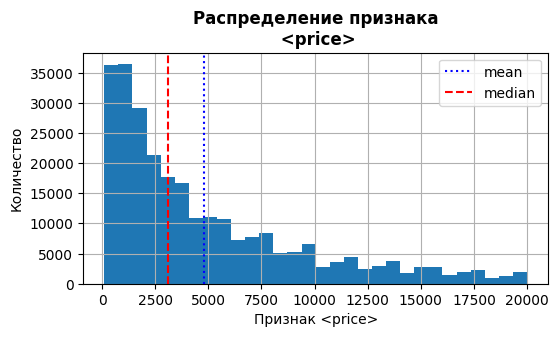

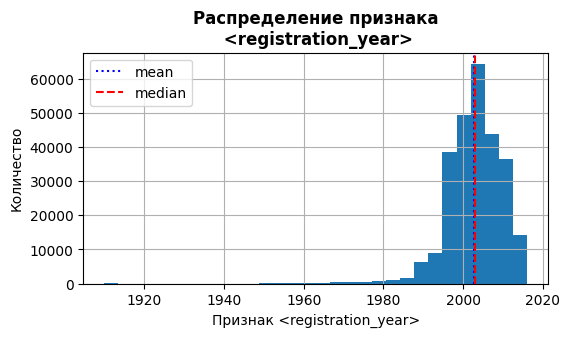

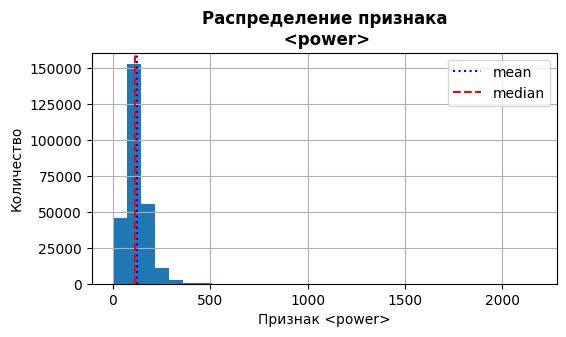

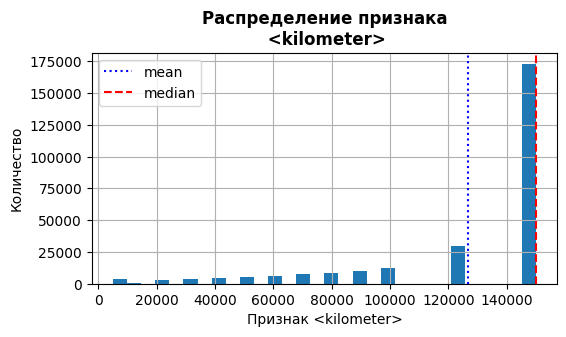

In [54]:
# функция для построения гистограммы
def get_hist(df, item):
    mean_value = df[item].mean()
    median_value = df[item].median()
    df[item].hist(bins=30)
    plt.title(f"Распределение признака\n <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество")
    plt.axvline(x=mean_value, label="mean", color="b", linestyle=":")
    plt.axvline(x=median_value, label="median", color="r", linestyle="--")
    plt.legend()
    plt.show()


# построение гистограммы
set_plot(
    autos_df,
    autos_num_lst,
    get_hist,
)

На гистограммах распределения:
 - по признаку `'price'` - распределение смещённое, с большим "хвостом" справа
 - по признаку `'registration_year'` - распределение смещённое, с большим "хвостом" слева
 - по признаку `'power'` - распределение смещённое, с большим "хвостом" справа

***

**ВЫВОД:**

1. Для большей наглядности и выявления выбросов были построены диаграммы размаха для количественных признаков датафрейма.
2. На диаграммах размаха:
   - по признаку `'price'` - выше края статистически значимой выборки большое количество выбросов,\
      также присутствуют значения около нуля.
   - по признаку `'registration_year'` - большое количество выбросов выше и ниже края статистически значимой выборки.
   - по признаку `'power'` - выше края статистически значимой выборки большое количество выбросов,\
      также присутствуют значения около нуля.
   - по признаку `'kilometer'` - есть несколько выбросов ниже края статистически значимой выборки.
3. Были найдены объективные пределы мощностей для признака `'power'` - 0.75 л.с. и 2300 л.с.
4. Значения признака `'power'` вне указанных пределов были заполнены медианой для каждой уникальной пары признаков `'brand'` и `'model'`
5. Оставшиеся нулевые значения признака `'power'` были удалены.
6. По признаку `'registration_year'` выявлено большое количество нереальных значений - 13698,
    что составляет 3.87 % от первоначального размера датафрейма.
7. Строки с нереальными значениями признака `'registration_year'` были удалены.
8. В целевом признаке `'price'` присутствуют значения около нуля.
9. На 1 % значений с нижнего края датафрейма в признаке `'price'` приходится 2298 строк.
10. Эти строки были удалены.
11. После предобработки данных была проведена проверка на явные дубликаты. 56794 строк удалено.
8. Был выведен результат предобработки:\
    Датафрейм содержит 267945 строк.\
    Первоначальный датафрейм содержал 354369 строк.\
    Удалено 86424 строк.\
    Это примерно 24.39% от первоначального размера датафрейма.
9. После преобработки была выведена описательная статистика для количественных признаков датафрейма:\
    По признаку `'registration_year'` (2002.8 и 2003) среднее и медиана отличаются несущественно.\
    По признаку `'power'` (121.7 и 113) среднее и медиана отличаются существенно,\
    и стандартное отклонение достаточно большое (64.365).\
    По признакам `'price'` (4817.27 и 3100) и `'kilometer'` (126781 и 150000) среднее и медиана имеют существенное отличие.\
    И стандартные отклонения по этим признакам тоже велики.
10. Для количественных признаков датафрейма были построены гистограммы распределения.
11. На гистограммах распределения:
    - по признаку `'price'` - распределение смещённое, с большим "хвостом" справа
    - по признаку `'registration_year'` - распределение смещённое, с большим "хвостом" слева
    - по признаку `'power'` - распределение смещённое, с большим "хвостом" справа

## Анализ категориальных признаков датафрейма

Выведем описательную статистику для категориальных признаков датасета

In [55]:
# объявление списка категориальных признаков
autos_cat_lst = autos_df.select_dtypes(exclude=["number"]).columns.to_list()

# вывод описательной статистики для категориальных признаков датасета
autos_df[[*autos_cat_lst]].describe().round(3)

,vehicle_type,gearbox,model,fuel_type,brand,repaired
count,267945,267945,267945,267945,267945,267945
unique,8,3,249,7,39,2
top,sedan,manual,unknown,petrol,volkswagen,no
freq,73946,193966,23640,181215,53622,238697


В датафрейме 6 категориальных признаков:\
один из них `'repaired'` - бинарный.

Для категориальных признаков датасета построим столбчатые диаграммы

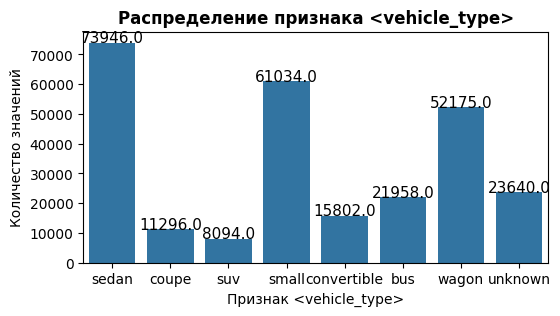

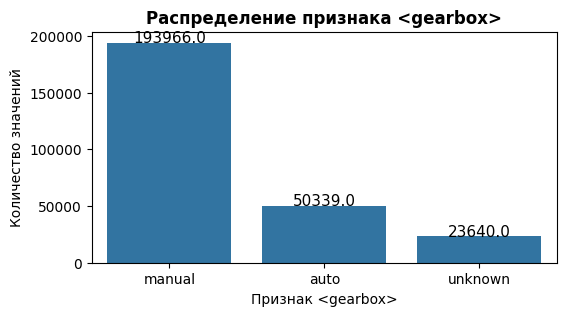

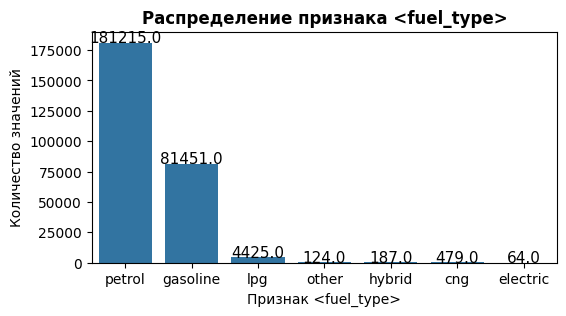

In [56]:
# функция для построения столбчатой диаграммы
def get_countplot(df, item):
    countplt, ax = plt.subplots()
    sns.countplot(x=item, data=df)
    plt.title(f"Распределение признака <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество значений")
    for rect in ax.patches:
        (
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_height() + 0.75,
                rect.get_height(),
                horizontalalignment="center",
                fontsize=11,
            )
        )
    plt.show()


# построение столбчатой диаграммы
set_plot(autos_df, ["vehicle_type", "gearbox", "fuel_type"], get_countplot)

По всем признакам наблюдается дисбаланс классов.

***

**ВЫВОД:**

1. В датафрейме 6 категориальных признаков:\
   один из них `'repaired'` - бинарный.
2. Для категориальных признаков датасета были построены столбчатые диаграммы.
3. По всем признакам наблюдается дисбаланс классов.

## Корреляционный анализ

Построим матрицу корреляции Фи

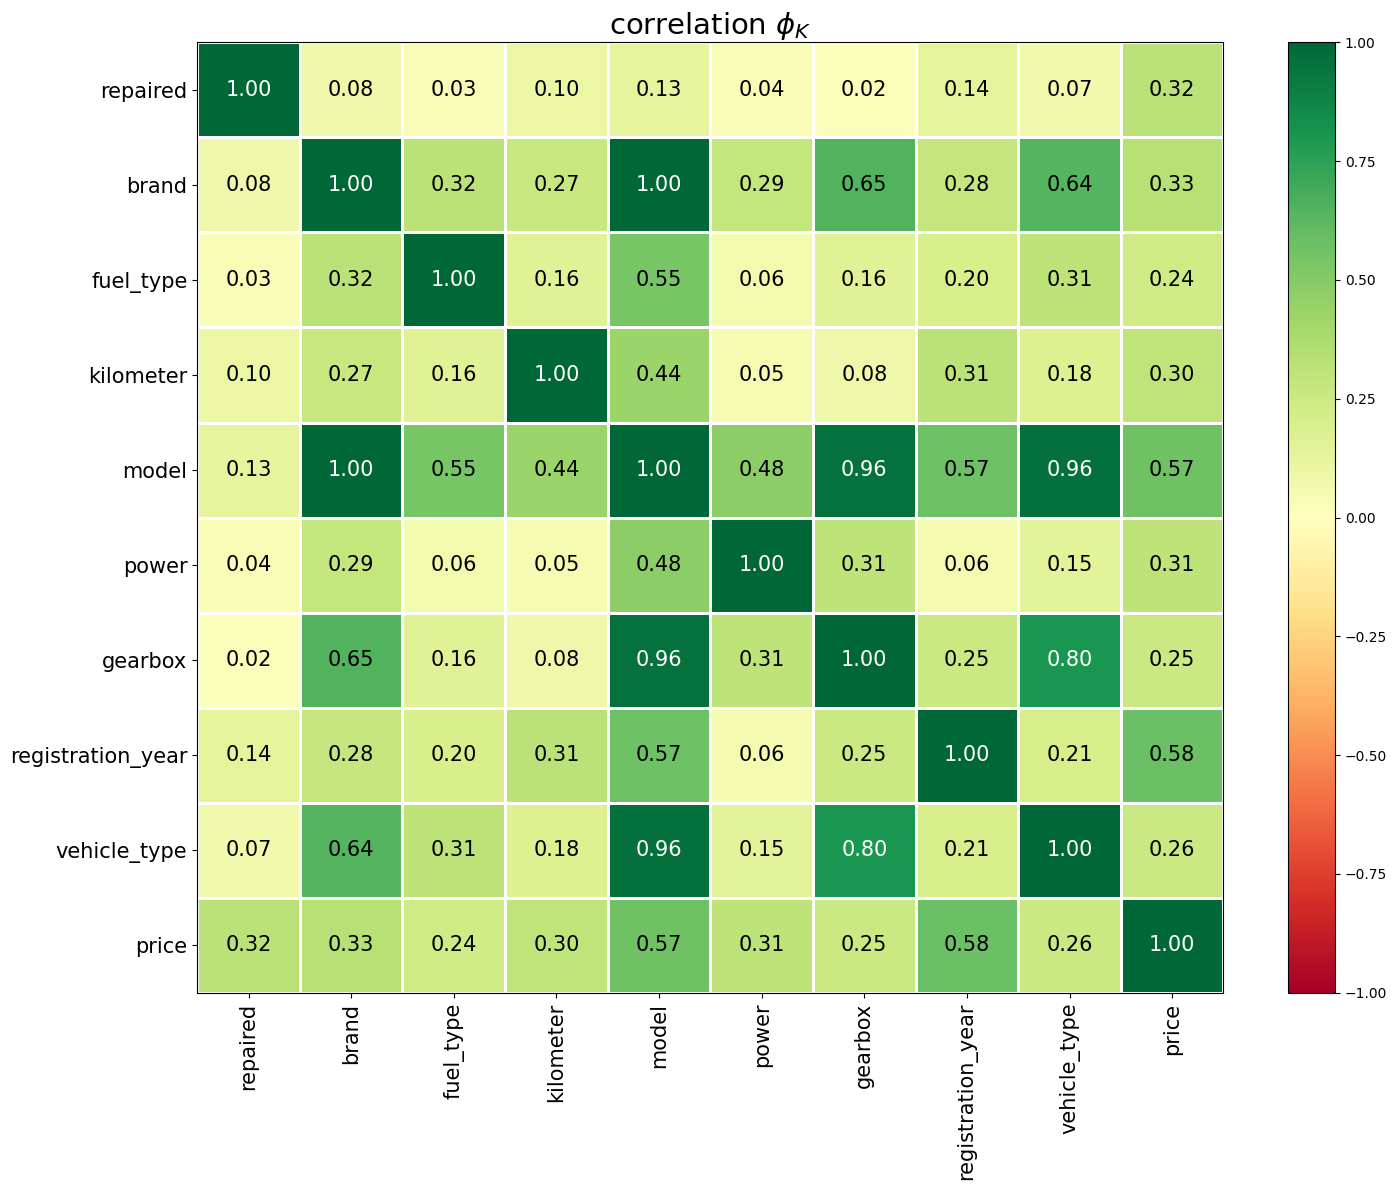

In [57]:
# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = autos_df.phik_matrix(interval_cols=autos_num_lst)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12),
)

Между целевым признаком `'price'` и входными наблюдается взаимозависимость согласно шкале Чеддока:
- с признаком `'model'` - заметная
- с признаком `'registration_year'` - заметная
- с признаком `'repaired'` - умеренная
- с признаком `'brand'` - умеренная
- с признаком `'power'` - умеренная
- с признаком `'fuel_type'` - слабая
- с признаком `'kilometer'` - слабая
- с признаком `'gearbox'` - слабая
- с признаком `'vehicle_type'` - слабая

Также наблюдается взаимозависимость между входными признаками:
- `'model'` и `'brand'` - весьма высокая
- `'model'` и `'gearbox'` - весьма высокая
- `'model'` и `'vehicle_type'` - весьма высокая
- `'gearbox'` и `'vehicle_type'` - высокая
- `'brand'` и `'gearbox'` - заметная
- `'brand'` и `'vehicle_type'` - заметная
- `'model'` и `'registration_year'` - заметная
- `'model'` и `'fuel_type'` - заметная

Между признаками есть мультиколлинеарность:
- `'model'` и `'brand'`
- `'model'` и `'gearbox'`
- `'model'` и `'vehicle_type'`

<a id='4'></a>
# Подготовка данных

Перед подготовкой удалим лишние переменные

In [58]:
del autos_cat_lst
del autos_num_lst
del get_read_file
del autos_rows_before
del brand_grp
del general_path
del get_boxplot
del get_countplot
del get_hist
del get_str_values
del i
del index
del item
del model_grp
del power_grp
del rename_columns
del set_plot
del user_path

Так как тагрет - количественный признак, будем решать задачу регрессии.

Для построения модели используем пайплайны.\
Для подготовки данных будем использовать ColumnTransformer.\
Для кодирования категориальных признаков будем использовать кодировщики:
 - OneHotEncoder()
 - OrdinalEncoder()

Для масштабирования количественных признаков будем использовать скейлеры:
 - MinMaxScaler()
 - StandardScaler()
 - RobustScaler()
 - и аргумент "passthrough" - вариант без масштабирования.

Разделим тренировочный датафрейм.

In [59]:
# разделение датафрейма на целевой и входные признаки
X = autos_df.drop(columns="price")
y = autos_df["price"]

In [60]:
# формирование тренировочной и тестовой выборок
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

Проверим разделение

In [61]:
print(f"Размер обучающей {X_train.shape} и тестовой {X_test.shape} выборок.")
print(f"Размер таргета обучающей {y_train.shape} и тестовой {y_test.shape} выборок.")

Размер обучающей (200958, 9) и тестовой (66987, 9) выборок.
Размер таргета обучающей (200958,) и тестовой (66987,) выборок.


Преобразуем таргеты тестовой и тренировочной части в массивы.

In [62]:
# преобразование в массивы NumPy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Создадим списки входных признаков для кодирования и масштабирования.

In [63]:
# создание списков с признаками
ohe_columns = ["vehicle_type", "gearbox", "model", "fuel_type", "brand"]
ord_columns = ["repaired"]
num_columns = X.select_dtypes(include=["number"]).columns.to_list()

In [64]:
# создание pipeline для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        (
            "simpleImputer_ohe",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "ohe",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
        ),
    ]
)

In [65]:
# создание pipeline для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            "simpleImputer_before_ord",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "ord",
            OrdinalEncoder(
                categories=[
                    ["no", "yes"],
                ],
                handle_unknown="use_encoded_value",
                unknown_value=np.nan,
            ),
        ),
        (
            "simpleImputer_after_ord",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
    ]
)

In [66]:
# создание общего pipeline для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ("ohe", ohe_pipe, ohe_columns),
        ("ord", ord_pipe, ord_columns),
        ("num", MinMaxScaler(), num_columns),
    ],
    remainder="passthrough",
)

***

**ВЫВОД:**

1. Для подготовки данных были выбраны кодировщики и скейлеры.
2. Датафрейм был разделён на выборки: тренировочную и тестовую.
3. Был создан пайплайн для подготовки данных

<a id='5'></a>
# Обучение моделей

Будем обучать модели с гиперпараметрами:
 - LinearRegression() (как dummy-модель для проверки на адекватность)
 - RandomForestRegressor() с ***max_depth***, ***n_estimators***
 - LGBMRegressor() с ***max_depth***, ***num_leaves***
 - GradientBoostingRegressor() с ***max_depth***, ***min_samples_split***

Для подбора лучшей модели с гиперпараметрами будем использовать
 - RandomizedSearchCV()

Для оценки качества работы модели применим метрику RMSE

Создадим итоговый пайплайн

In [67]:
# создание итогового pipeline с инициализацией модели
pipe_final = Pipeline(
    [
        ("preprocessor", data_preprocessor),
        ("models", LinearRegression()),
    ]
)

Опишем модели с гиперпараметрами

In [68]:
param_grid = [
    # словарь для модели LinearRegression()
    {
        "models": [LinearRegression()],
        "preprocessor__ord": [OneHotEncoder(drop="first", sparse_output=False)],
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели RandomForestRegressor()
    {
        "models": [RandomForestRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(2, 20, 2),
        "models__n_estimators": range(3, 20, 2),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели LGBMRegressor()
    {
        "models": [LGBMRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(3, 10, 3),
        "models__num_leaves": range(2, 10),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели GradientBoostingRegressor()
    {
        "models": [GradientBoostingRegressor()],
        "models__max_depth": range(3, 7, 3),
        "models__min_samples_split": range(4, 11, 2),
        "models__n_estimators": range(11, 20, 2),
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
]

## LinearRegression()

Обучим модель **LinearRegression()**, получим её предсказания и рассчитаем метрику

In [69]:
# подбор лучшей модели с гиперпараметрами
rs_LinearRegression = RandomizedSearchCV(
    pipe_final,
    param_grid[0],
    scoring="neg_root_mean_squared_error",
    n_iter=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rs_LinearRegression.fit(X_train, y_train)

print("Лучшая модель и её параметры:\n\n", rs_LinearRegression.best_estimator_)
print(
    f"Качество модели по метрике RMSE - {round(rs_LinearRegression.best_score_, 3)*-1}"
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand']),
                           

Проверим скорость обучения созданной модели **LinearRegression()**

In [70]:
%%timeit -n 2 -r 2
rs_LinearRegression.fit(X_train, y_train)

1min 31s ± 335 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Проверим скорость работы созданной модели **LinearRegression()** с заданными гиперпараметрами

In [71]:
%%timeit -n 2 -r 2
rs_LinearRegression.predict(X_train)

1.27 s ± 4.09 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


## RandomForestRegressor()

Обучим модель **RandomForestRegressor()**, подберём гиперпараметры, получим её предсказания и рассчитаем метрику

In [72]:
# подбор лучшей модели с гиперпараметрами
rs_RandomForestRegressor = RandomizedSearchCV(
    pipe_final,
    param_grid[1],
    scoring="neg_root_mean_squared_error",
    n_iter=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rs_RandomForestRegressor.fit(X_train, y_train)

print("Лучшая модель и её параметры:\n\n", rs_RandomForestRegressor.best_estimator_)
print(
    f"Качество модели по метрике RMSE - {round(rs_RandomForestRegressor.best_score_, 3)*-1}"
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand']),
                           

Проверим скорость обучения созданной модели **RandomForestRegressor()** с заданными гиперпараметрами

In [73]:
%%timeit -n 2 -r 2
rs_RandomForestRegressor.fit(X_train, y_train)

11min 7s ± 2.52 s per loop (mean ± std. dev. of 2 runs, 2 loops each)


Проверим скорость работы созданной модели **RandomForestRegressor()** с заданными гиперпараметрами

In [74]:
%%timeit -n 2 -r 2
rs_RandomForestRegressor.predict(X_train)

2.37 s ± 8.68 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


## LGBMRegressor()

Обучим модель **LGBMRegressor()**, подберём гиперпараметры, получим её предсказания и рассчитаем метрику

In [75]:
# подбор лучшей модели с гиперпараметрами
rs_LGBMRegressor = RandomizedSearchCV(
    pipe_final,
    param_grid[2],
    scoring="neg_root_mean_squared_error",
    n_iter=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rs_LGBMRegressor.fit(X_train, y_train)

print("Лучшая модель и её параметры:\n\n", rs_LGBMRegressor.best_estimator_)
print(f"Качество модели по метрике RMSE - {round(rs_LGBMRegressor.best_score_, 3)*-1}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 200958, number of used features: 287
[LightGBM] [Info] Start training from score 4818.885663
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                          

Проверим скорость обучения созданной модели **LGBMRegressor()** с заданными гиперпараметрами

In [76]:
%%timeit -n 2 -r 2
rs_LGBMRegressor.fit(X_train, y_train);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 200958, number of used features: 287
[LightGBM] [Info] Start training from score 4818.885663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 200958, number of used features: 287
[LightGBM] [Info] Start training from score 4818.885663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

Проверим скорость работы созданной модели **LGBMRegressor()** с заданными гиперпараметрами

In [77]:
%%timeit -n 2 -r 2
rs_LGBMRegressor.predict(X_train)

1.53 s ± 20.4 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


## GradientBoostingRegressor()

Обучим модель **GradientBoostingRegressor()**, подберём гиперпараметры, получим её предсказания и рассчитаем метрику

In [78]:
# подбор лучшей модели с гиперпараметрами
rs_GradientBoostingRegressor = RandomizedSearchCV(
    pipe_final,
    param_grid[3],
    scoring="neg_root_mean_squared_error",
    n_iter=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rs_GradientBoostingRegressor.fit(X_train, y_train)

print("Лучшая модель и её параметры:\n\n", rs_GradientBoostingRegressor.best_estimator_)
print(
    f"Качество модели по метрике RMSE - {round(rs_GradientBoostingRegressor.best_score_, 3)*-1}"
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand']),
                           

Проверим скорость обучения созданной модели **GradientBoostingRegressor()** с заданными гиперпараметрами

In [79]:
%%timeit -n 2 -r 2
rs_GradientBoostingRegressor.fit(X_train, y_train)

14min 40s ± 1.5 s per loop (mean ± std. dev. of 2 runs, 2 loops each)


Проверим скорость работы созданной модели **GradientBoostingRegressor()** с заданными гиперпараметрами

In [80]:
%%timeit -n 2 -r 2
rs_GradientBoostingRegressor.predict(X_train)

1.9 s ± 2.84 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


***

**ВЫВОД:**

1. Были обучены модели с гиперпараметрами:
   - LinearRegression() (как dummy-модель для проверки на адекватность)
   - RandomForestRegressor() с ***max_depth***, ***n_estimators***
   - LGBMRegressor() с ***max_depth***, ***n_estimators***, ***num_leaves***
   - GradientBoostingRegressor() с ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
2. Для подбора лучшей модели с гиперпараметрами будем использовать
   - RandomizedSearchCV()
3. Для оценки качества работы модели применим метрику RMSE

<a id='6'></a>
# Анализ моделей

Проанализируем время обучения, время предсказания и качество моделей.

|Модель|Время обучения|Время предсказания|Качество модели|
|-|-:|-:|-:|
|LinearRegression()|3min 9s|539 ms|2902.686|
|RandomForestRegressor()|8min 13s|1.95 s|1799.039|
|LGBMRegressor()|3min 5s|2.55 s|1974.699|
|GradientBoostingRegressor()|20min 16s|1.77 s|2297.735|

Все модели прошли проверку на адекватность: их метрики лучше, чем у модели **LinearRegression()**

Лучшая модель по времени обучения - **LGBMRegressor()** с гиперпараметрами ***max_depth*** = 9, ***num_leaves*** = 6

Лучшая модель по времени предсказания - **LinearRegression()**

Лучшая модель по качеству - **RandomForestRegressor()** с гиперпараметрами ***max_depth*** = 16, ***n_estimators*** = 11

Несмотря на то, что модель **RandomForestRegressor()** обучается в 2,6 раза дольше, чем **LGBMRegressor()**,\
признаем модель **RandomForestRegressor()** лучшей.

Модель **RandomForestRegressor()** имеет лучшую метрику, и время предсказания у модели меньше,\
чем у **LGBMRegressor()**

Проверим работу модели **RandomForestRegressor()** на тестовой выборке

In [81]:
# получение предсказаний на тренировочной выборке
pred = rs_RandomForestRegressor.predict(X_test)
# получение предсказаний модели
print(
    f"Качество модели по метрике RMSE на тестовой выборке - {round(root_mean_squared_error(y_test, pred), 3)}"
)

Качество модели по метрике RMSE на тестовой выборке - 1772.151


***

***ВЫВОД:***

1. Лучшая модель по качеству - **RandomForestRegressor()** с гиперпараметрами ***max_depth*** = 16, ***n_estimators*** = 11
2. Так как качество модели - важная метрика модели, то лучшей моделью признается **RandomForestRegressor()**
3. Качество модели **RandomForestRegressor()** на тестовой выборке по метрике RMSE - 1772.151

<a id='7'></a>
# ОБЩИЙ ВЫВОД

**ВХОДНЫЕ ДАННЫЕ:**
1. Исследование проведено на базе данных сервиса по продаже автомобилей с пробегом "Не бит, не крашен"
2. Данные представлены файлом autos.csv
3. Данные получены и записаны в датафрейм ***autos_df***
4. В результате изучения общей информации о датафрейме обнаружено некорректное наименование столбцов:
    - сочетание прописных и строчных букв
    - стиль написания, отличный от "lower_case_with_underscores"
5. Наименования столбцов приведены к стандартам оформления данных.



**НА ЭТАПЕ ПРЕДОБРАБОТКИ ДАННЫХ:**
1. В датафрейме наблюдается большое количество пропусков:

   |Пропусков|`'repaired'`|`'vehicle_type'`|`'fuel_type'`|`'gearbox'`|`'model'`|
   |-|-:|-:|-:|-:|-:|
   |количество|71154|37490|32895|19833|19705|
   |процент|20.08|10.58|9.28|5.6|5.56|

2. Так как пропусков большое количество, их нельзя просто удалить.
3. Пропуски во входном признаке `'model'` были заполнены самыми часто встречающимися значениями для входного признака `'brand'`
4. Пропуски во входных признаках:
    - `'vehicle_type'`
    - `'fuel_type'`
    - `'gearbox'`\
     были заполнены самыми часто встречающимися значениями для входного признака `'model'`
5. Пропуски во входном признаке `'repaired'` были заполнены значением ***'no'***
6. В датафрейме обнаружены 5 явных дубликатов.
7. Явные дубликаты были удалены.
8. Тип данных входного признака `'repaired'` не соответствует данным:\
    тип данных в данный момент - *object*,\
    нужный тип данных - категориальный бинарный.
9. Преобразование типа данных признака `'repaired'` необходимо провести в пайплайне.
10. Данные были проверены на наличие неявных дубликатов значений.
11. В значениях входного признака `'model'` были обнаружены неявные дубликаты в 2-х значениях:
    *"range_rover"* и *"rangerover"*
12. Значения приведены к единому виду - *"range_rover"*
13. Был получен диапазон дат по каждому признаку с датой и временем.
14. Входные признаки были признаны неинформативными:
    - `'postal_code'`
    - `'registration_month'`
    - `'number_of_pictures'`
    - `'date_crawled'`
    - `'date_created'`
    - `'last_seen'`
15. Неинформативные признаки были удалены.
16. Было определено количество строк датафрейма со значением признаков *"other"* - 27526 строк
17. Эти значения были заменены на *"unknown"*



**НА ЭТАПЕ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА ДАННЫХ:**

1. Для большей наглядности и выявления выбросов были построены диаграммы размаха для количественных признаков датафрейма.
2. На диаграммах размаха:
   - по признаку `'price'` - выше края статистически значимой выборки большое количество выбросов,\
      также присутствуют значения около нуля.
   - по признаку `'registration_year'` - большое количество выбросов выше и ниже края статистически значимой выборки.
   - по признаку `'power'` - выше края статистически значимой выборки большое количество выбросов,\
      также присутствуют значения около нуля.
   - по признаку `'kilometer'` - есть несколько выбросов ниже края статистически значимой выборки.
3. Были найдены объективные пределы мощностей для признака `'power'` - 0.75 л.с. и 2300 л.с.
4. Значения признака `'power'` вне указанных пределов были заполнены медианой для каждой уникальной пары признаков `'brand'` и `'model'`
5. Оставшиеся нулевые значения признака `'power'` были удалены.
6. По признаку `'registration_year'` выявлено большое количество нереальных значений - 13698,
    что составляет 3.87 % от первоначального размера датафрейма.
7. Строки с нереальными значениями признака `'registration_year'` были удалены.
8. В целевом признаке `'price'` присутствуют значения около нуля.
9. На 1 % значений с нижнего края датафрейма в признаке `'price'` приходится 2298 строк.
10. Эти строки были удалены.
11. После предобработки данных была проведена проверка на явные дубликаты. 56794 строк удалено.
8. Был выведен результат предобработки:\
    Датафрейм содержит 267945 строк.\
    Первоначальный датафрейм содержал 354369 строк.\
    Удалено 86424 строк.\
    Это примерно 24.39% от первоначального размера датафрейма.
9. После преобработки была выведена описательная статистика для количественных признаков датафрейма:\
    По признаку `'registration_year'` (2002.8 и 2003) среднее и медиана отличаются несущественно.\
    По признаку `'power'` (121.7 и 113) среднее и медиана отличаются существенно,\
    и стандартное отклонение достаточно большое (64.365).\
    По признакам `'price'` (4817.27 и 3100) и `'kilometer'` (126781 и 150000) среднее и медиана имеют существенное отличие.\
    И стандартные отклонения по этим признакам тоже велики.
10. Для количественных признаков датафрейма были построены гистограммы распределения.
11. На гистограммах распределения:
    - по признаку `'price'` - распределение смещённое, с большим "хвостом" справа
    - по признаку `'registration_year'` - распределение смещённое, с большим "хвостом" слева
    - по признаку `'power'` - распределение смещённое, с большим "хвостом" справа
12. В датафрейме 6 категориальных признаков: один из них 'repaired' - бинарный.
13. Для категориальных признаков датасета были построены столбчатые диаграммы
14. По всем категориальным признакам наблюдается дисбаланс классов.



**НА ЭТАПЕ ПОДГОТОВКИ ДАННЫХ:**
1. Для построения модели были использованы пайплайны.
2. Для подготовки данных был использован ColumnTransformer.
3. Для кодирования категориальных признаков были использованы кодировщики:
    - OneHotEncoder()
    - OrdinalEncoder()
4. Для масштабирования количественных признаков были использованы скейлеры:
    - MinMaxScaler()
    - StandardScaler()
    - RobustScaler()
    - и аргумент "passthrough" - вариант без масштабирования.
5. Датафрейм был разделён на выборки: тренировочную и тестовую.
6. Был создан пайплайн для подготовки данных



**НА ЭТАПЕ ОБУЧЕНИЯ МОДЕЛЕЙ:**
1. Были обучены модели с гиперпараметрами:
    - LinearRegression() (как dummy-модель для проверки на адекватность)
    - RandomForestRegressor() с ***max_depth***, ***n_estimators***
    - LGBMRegressor() с ***max_depth***, ***num_leaves***
    - GradientBoostingRegressor() с ***max_depth***, ***min_samples_split***
2. Для подбора лучшей модели с гиперпараметрами был использован
    - RandomizedSearchCV()
3. При подборе лучшей модели был использован общий пайплайн для всех моделей\
    и инструмент подбора гиперпараметров.
4. Для оценки качества модели была использована метрика RMSE



**НА ЭТАПЕ АНАЛИЗА МОДЕЛЕЙ:**
1. Критерии для отбора лучшей модели собраны в таблице:
   -|Модель|Время обучения|Время предсказания|Качество модели|
   -|-|-:|-:|-:|
   -|LinearRegression()|3min 9s|539 ms|2902.686|
   -|RandomForestRegressor()|8min 13s|1.95 s|1799.039|
   -|LGBMRegressor()|3min 5s|2.55 s|1974.699|
   -|GradientBoostingRegressor()|20min 16s|1.77 s|2297.735|
2. Лучшая модель по качеству - **RandomForestRegressor()** с гиперпараметрами ***max_depth*** = 16, ***n_estimators*** = 11
3. Так как качество модели - важная метрика модели, то лучшей моделью признается **RandomForestRegressor()**
4. Качество модели **RandomForestRegressor()** на тестовой выборке по метрике RMSE - 1772.151




**ВЫВОД:**
1. Заказчику можно рекомендовать использование модели **RandomForestRegressor()** с гиперпараметрами ***max_depth*** = 16, ***n_estimators*** = 11\
    для прогнозирования рыночной стоимости автомобилей.